In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    ##################################################### repeatable!
    next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
                                   reuse=True)
    next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
                                reuse=True)
    gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
                         action_size=action_size, reuse=True)
    dones = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                    labels=tf.zeros_like(gQs3))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
                                                                     labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2, (1-dones)

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.dones__ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates >= np.max(rates)]
            actions = actions[rates >= np.max(rates)]
            next_states = next_states[rates >= np.max(rates)]
            rewards = rewards[rates >= np.max(rates)]
            dones = dones[rates >= np.max(rates)]
            rates = rates[rates >= np.max(rates)]
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _, dones__ = sess.run([model.a_loss2, model.a_opt2, model.dones__], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            #print(dones__)
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:20.0000 R:20.0000 rate:0.0400 aloss:1.3870 dloss:2.7149 aloss2:2.1020 exploreP:0.9980
Episode:1 meanR:20.5000 R:21.0000 rate:0.0420 aloss:1.3830 dloss:2.7257 aloss2:2.0939 exploreP:0.9959
Episode:2 meanR:43.0000 R:88.0000 rate:0.1760 aloss:1.3838 dloss:2.6728 aloss2:2.1267 exploreP:0.9873
Episode:3 meanR:35.5000 R:13.0000 rate:0.0260 aloss:1.3766 dloss:2.6221 aloss2:2.1547 exploreP:0.9860
Episode:4 meanR:32.0000 R:18.0000 rate:0.0360 aloss:1.3799 dloss:2.6599 aloss2:2.1370 exploreP:0.9843
Episode:5 meanR:30.3333 R:22.0000 rate:0.0440 aloss:1.3810 dloss:2.5922 aloss2:2.1730 exploreP:0.9821
Episode:6 meanR:31.4286 R:38.0000 rate:0.0760 aloss:1.3776 dloss:2.6015 aloss2:2.1717 exploreP:0.9785
Episode:7 meanR:29.2500 R:14.0000 rate:0.0280 aloss:1.3808 dloss:2.5870 aloss2:2.1814 exploreP:0.9771
Episode:8 meanR:29.2222 R:29.0000 rate:0.0580 aloss:1.3809 dloss:2.5800 aloss2:2.1816 exploreP:0.9743
Episode:9 meanR:28.5000 R:22.0000 rate:0.0440 aloss:1.3805 dloss:2.5371 aloss2:2.2

Episode:80 meanR:24.4074 R:25.0000 rate:0.0500 aloss:1.3620 dloss:0.9546 aloss2:5.2878 exploreP:0.8224
Episode:81 meanR:24.5000 R:32.0000 rate:0.0640 aloss:1.3698 dloss:0.9480 aloss2:5.3566 exploreP:0.8198
Episode:82 meanR:24.5904 R:32.0000 rate:0.0640 aloss:1.3687 dloss:0.9331 aloss2:5.4065 exploreP:0.8172
Episode:83 meanR:24.4405 R:12.0000 rate:0.0240 aloss:1.3659 dloss:0.9329 aloss2:5.4567 exploreP:0.8163
Episode:84 meanR:24.4471 R:25.0000 rate:0.0500 aloss:1.3669 dloss:0.9111 aloss2:5.5145 exploreP:0.8142
Episode:85 meanR:24.3488 R:16.0000 rate:0.0320 aloss:1.3701 dloss:0.9083 aloss2:5.5889 exploreP:0.8130
Episode:86 meanR:24.3103 R:21.0000 rate:0.0420 aloss:1.3995 dloss:0.9381 aloss2:5.4609 exploreP:0.8113
Episode:87 meanR:24.4886 R:40.0000 rate:0.0800 aloss:1.3627 dloss:0.9149 aloss2:5.6488 exploreP:0.8081
Episode:88 meanR:24.5618 R:31.0000 rate:0.0620 aloss:1.3661 dloss:0.8746 aloss2:5.7412 exploreP:0.8056
Episode:89 meanR:24.6556 R:33.0000 rate:0.0660 aloss:1.3691 dloss:0.8636 

Episode:159 meanR:40.7200 R:25.0000 rate:0.0500 aloss:1.4158 dloss:0.6334 aloss2:9.7631 exploreP:0.5823
Episode:160 meanR:41.0600 R:49.0000 rate:0.0980 aloss:1.4189 dloss:0.6096 aloss2:9.8508 exploreP:0.5795
Episode:161 meanR:41.3600 R:41.0000 rate:0.0820 aloss:1.4031 dloss:0.6605 aloss2:9.8289 exploreP:0.5772
Episode:162 meanR:41.8300 R:79.0000 rate:0.1580 aloss:1.4134 dloss:0.6455 aloss2:9.7476 exploreP:0.5727
Episode:163 meanR:43.3700 R:174.0000 rate:0.3480 aloss:1.4233 dloss:0.6241 aloss2:9.7982 exploreP:0.5630
Episode:164 meanR:43.3900 R:22.0000 rate:0.0440 aloss:1.4409 dloss:0.6123 aloss2:9.9578 exploreP:0.5618
Episode:165 meanR:43.4900 R:32.0000 rate:0.0640 aloss:1.4581 dloss:0.6626 aloss2:9.8235 exploreP:0.5600
Episode:166 meanR:44.3900 R:110.0000 rate:0.2200 aloss:1.4229 dloss:0.5983 aloss2:10.0279 exploreP:0.5540
Episode:167 meanR:46.2000 R:200.0000 rate:0.4000 aloss:1.4362 dloss:0.6208 aloss2:10.0684 exploreP:0.5433
Episode:168 meanR:47.6000 R:177.0000 rate:0.3540 aloss:1.44

Episode:238 meanR:96.2200 R:106.0000 rate:0.2120 aloss:1.4309 dloss:0.7049 aloss2:9.6995 exploreP:0.2529
Episode:239 meanR:96.0500 R:72.0000 rate:0.1440 aloss:1.4407 dloss:0.7574 aloss2:9.5359 exploreP:0.2511
Episode:240 meanR:95.8600 R:62.0000 rate:0.1240 aloss:1.4425 dloss:0.7091 aloss2:9.5197 exploreP:0.2497
Episode:241 meanR:97.2500 R:183.0000 rate:0.3660 aloss:1.4417 dloss:0.6826 aloss2:9.5569 exploreP:0.2453
Episode:242 meanR:98.0500 R:144.0000 rate:0.2880 aloss:1.4038 dloss:0.7115 aloss2:9.5727 exploreP:0.2419
Episode:243 meanR:100.4600 R:322.0000 rate:0.6440 aloss:1.4485 dloss:0.7321 aloss2:9.4717 exploreP:0.2346
Episode:244 meanR:101.0700 R:79.0000 rate:0.1580 aloss:1.4399 dloss:0.6923 aloss2:9.4560 exploreP:0.2328
Episode:245 meanR:101.7400 R:82.0000 rate:0.1640 aloss:1.4366 dloss:0.6961 aloss2:9.5029 exploreP:0.2310
Episode:246 meanR:102.9300 R:195.0000 rate:0.3900 aloss:1.4112 dloss:0.6795 aloss2:9.5837 exploreP:0.2267
Episode:247 meanR:103.0300 R:68.0000 rate:0.1360 aloss:

Episode:316 meanR:99.0500 R:62.0000 rate:0.1240 aloss:1.4083 dloss:0.6783 aloss2:9.3305 exploreP:0.1255
Episode:317 meanR:98.6600 R:96.0000 rate:0.1920 aloss:1.3833 dloss:0.8495 aloss2:9.3292 exploreP:0.1244
Episode:318 meanR:98.9900 R:114.0000 rate:0.2280 aloss:1.4157 dloss:0.7889 aloss2:9.3292 exploreP:0.1231
Episode:319 meanR:98.6300 R:65.0000 rate:0.1300 aloss:1.4179 dloss:0.7010 aloss2:9.2720 exploreP:0.1224
Episode:320 meanR:98.2900 R:63.0000 rate:0.1260 aloss:1.3959 dloss:0.6938 aloss2:9.3784 exploreP:0.1217
Episode:321 meanR:98.6900 R:122.0000 rate:0.2440 aloss:1.3950 dloss:0.7206 aloss2:9.4471 exploreP:0.1203
Episode:322 meanR:98.6700 R:89.0000 rate:0.1780 aloss:1.3983 dloss:0.7547 aloss2:9.4775 exploreP:0.1193
Episode:323 meanR:97.8200 R:124.0000 rate:0.2480 aloss:1.4094 dloss:0.7487 aloss2:9.3449 exploreP:0.1180
Episode:324 meanR:97.5500 R:71.0000 rate:0.1420 aloss:1.4038 dloss:0.8050 aloss2:9.1326 exploreP:0.1172
Episode:325 meanR:95.8500 R:69.0000 rate:0.1380 aloss:1.3925 

Episode:395 meanR:90.1900 R:60.0000 rate:0.1200 aloss:1.4113 dloss:0.8082 aloss2:8.9986 exploreP:0.0657
Episode:396 meanR:90.4700 R:95.0000 rate:0.1900 aloss:1.4155 dloss:0.8254 aloss2:8.9407 exploreP:0.0652
Episode:397 meanR:90.5000 R:88.0000 rate:0.1760 aloss:1.3976 dloss:0.7657 aloss2:9.1210 exploreP:0.0647
Episode:398 meanR:90.3100 R:56.0000 rate:0.1120 aloss:1.4036 dloss:0.7848 aloss2:9.1147 exploreP:0.0644
Episode:399 meanR:89.9200 R:56.0000 rate:0.1120 aloss:1.4012 dloss:0.7435 aloss2:9.2371 exploreP:0.0641
Episode:400 meanR:89.9400 R:70.0000 rate:0.1400 aloss:1.3944 dloss:0.8332 aloss2:9.2095 exploreP:0.0637
Episode:401 meanR:89.8200 R:58.0000 rate:0.1160 aloss:1.3918 dloss:0.8013 aloss2:9.1554 exploreP:0.0634
Episode:402 meanR:90.0100 R:77.0000 rate:0.1540 aloss:1.3895 dloss:0.8425 aloss2:9.0860 exploreP:0.0630
Episode:403 meanR:90.0600 R:69.0000 rate:0.1380 aloss:1.4137 dloss:0.7914 aloss2:9.0829 exploreP:0.0626
Episode:404 meanR:89.8100 R:52.0000 rate:0.1040 aloss:1.4004 dlo

Episode:474 meanR:79.3500 R:58.0000 rate:0.1160 aloss:1.4244 dloss:0.8579 aloss2:9.0200 exploreP:0.0401
Episode:475 meanR:79.0000 R:42.0000 rate:0.0840 aloss:1.4532 dloss:0.7305 aloss2:9.0674 exploreP:0.0400
Episode:476 meanR:79.9100 R:273.0000 rate:0.5460 aloss:1.4062 dloss:0.8249 aloss2:9.1088 exploreP:0.0392
Episode:477 meanR:78.4700 R:47.0000 rate:0.0940 aloss:1.4157 dloss:0.8160 aloss2:8.9215 exploreP:0.0391
Episode:478 meanR:78.4300 R:66.0000 rate:0.1320 aloss:1.3725 dloss:0.9516 aloss2:8.9368 exploreP:0.0389
Episode:479 meanR:79.4900 R:162.0000 rate:0.3240 aloss:1.4099 dloss:0.8416 aloss2:8.8931 exploreP:0.0384
Episode:480 meanR:79.3300 R:53.0000 rate:0.1060 aloss:1.3969 dloss:0.8250 aloss2:9.0234 exploreP:0.0383
Episode:481 meanR:79.1600 R:38.0000 rate:0.0760 aloss:1.4215 dloss:0.7616 aloss2:9.0503 exploreP:0.0382
Episode:482 meanR:78.7700 R:37.0000 rate:0.0740 aloss:1.4406 dloss:0.7974 aloss2:9.2219 exploreP:0.0381
Episode:483 meanR:78.6500 R:42.0000 rate:0.0840 aloss:1.3773 d

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

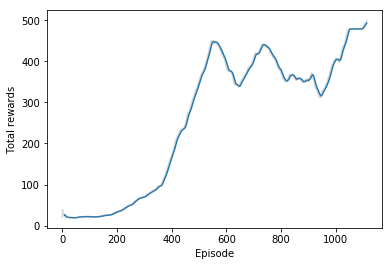

In [57]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

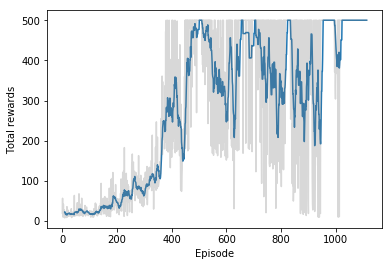

In [58]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 481.0
total_reward: 481.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.